In [2]:
import numpy as np
import matplotlib.pyplot as plt
import time
import cv2 as cv
import metodos as met
from skimage.morphology import remove_small_holes, area_opening, skeletonize, remove_small_objects
import pandas as pd

THRESHOLD = 120
MAX_PIXEL_VALUE = 255

### funciones que se usan

In [3]:
def cortar(frame, limites, PRUEBA=False, nombre='CORTE'):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    corte = frame[min_y:max_y, min_x:max_x] # resolver lo del corte binarizadp
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', corte)
    return corte

def gris(frame, PRUEBA=False, nombre='GRAYSCALE'):
    im_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gray)
    return im_gray

def binarize(frame, PRUEBA=False, nombre='BINARY'):
    # im_binary = cv.adaptiveThreshold(frame, 255, cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY, 11, 2)
    _, im_binary = cv.threshold(frame, THRESHOLD, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def find(frame):
    y, x = np.where(frame==0)
    x_head = np.min(x)
    filas = np.unique(y)
    y_head = int(np.mean(filas))
    return x, y, x_head, y_head

def tracker(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        pos_x = []
        pos_y = []
        
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        i=0
        while(vs.isOpened()):
            i+=1
            ret, frame = vs.read()

            if ret:
                frame = cortar(frame, limites)
                frame_bn = binarize(gris(frame))
                mask = frame_bn>0
                frame_bn = remove_small_holes(mask,10)*255
                try:
                    x, y, x_head, y_head = find(frame_bn)
                    pos_x.append(x_head)
                    pos_y.append(y_head)
                    if SHOW:
                        frame[y, x] = [0, 255, 0]
                        frame = cv.circle(frame, (x_head, y_head), radius=1, color=(0, 0, 255), thickness=-1)
                        cv.imshow('frame', frame)
                except:
                    break
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()
        # video.release()
        return np.array(tiempo), np.array(pos_x), np.array(pos_y)

def guillotina(frame, PRUEBA=False, nombre='DECAPITADO'):
    y, x = np.where(frame<=130)
    frame[y, x] = np.max(frame)
    frame -= np.min(frame)
    frame = (frame/np.max(frame))*255
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', frame)
    return frame

def binarize_TAIL(frame, PRUEBA=False, nombre='BINARY_TAIL'):
    _, im_binary = cv.threshold(frame, THRESHOLD, MAX_PIXEL_VALUE, cv.THRESH_BINARY)
    arr = im_binary > 0
    im_binary = remove_small_holes(arr)*255
    im_binary = area_opening(im_binary, 200)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_binary)
    return im_binary

def skeleton(frame, PRUEBA=False, nombre='ESQUELETO'):
    arr = frame < 255
    sk = skeletonize(arr)*255
    y, x = np.where(sk!=0)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', sk)
    return x, y

def track_TAIL(vs, limites, SHOW=False):
        # Crea las listas vacias que van a ser nuestras mediciones
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]
        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret:
                frame = cortar(frame, limites)
                frame_bn = binarize_TAIL(guillotina(gris(frame)))
                try:
                    x, y = skeleton(frame_bn)
                    frame[y, x] = [0, 0, 255]
                    cv.imshow('frame', frame)
                except:
                    break
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()
        # video.release()
                
        return np.array(tiempo)

### funciones que no se usan

In [ ]:
def filtrar(frame, PRUEBA=False, nombre='GAUSS'):
    im_gauss = cv.medianBlur(frame,5)
    if PRUEBA:
        cv.imwrite(f'{nombre}.jpg', im_gauss)
    return im_gauss

def autoTracker(vs, template, limites):
        # Crea las listas vacias que van a ser nuestras mediciones
        posiciones = []
        
        fps = vs.get(5)
        frame_count = vs.get(7)
        tiempo = [f for f in range(1, int(frame_count))]

        while(vs.isOpened()):
            ret, frame = vs.read()
            if ret:
                frame = binarize(gris(cortar(frame, limites)))
                posiciones.append(trackTemplate(frame, template, GRAFICAR=False))
                if cv.waitKey(1) & 0xFF == ord('q'):
                    break
            else:
                break
        cv.destroyAllWindows()
        # video.release()
                
        return np.array(tiempo), np.array(posiciones)

def trackTemplate(frame, template, GRAFICAR=False):
    # Leer frame
    if frame is None:
        return None, None    
    # Trackear el template
    res = cv.matchTemplate(frame, template, cv.TM_CCOEFF) # tiene problemas con el matchtemplate cuando le paso una imagen grayscaleada
    top_left = cv.minMaxLoc(res)[3]
    
    if GRAFICAR:
        # Dimensiones del template (para dibujar el rectángulo)
        w, h = template.shape[:-1]
        bottom_right = (top_left[0] + w, top_left[1] + h)

        cv.rectangle(frame, top_left, bottom_right, 255, 2)
        cv.imshow("corte", frame)
    
    return top_left[0]

def inverse(im):
    im_inv = cv.bitwise_not(im)
    cv.imwrite('inverse.jpg', im_inv)

    return im_inv

### prueba de una sola imagen

In [97]:
im = cv.imread('Camo Snapshot 2024-05-17 - 10-34-47.jpg')

im_cut = cortar(im, limites=[248, 932, 193, 519], PRUEBA=True)
im_gray = gris(im_cut, PRUEBA=True)
im_gauss = filtrar(im_gray, PRUEBA=True)

im_binary = binarize(im_gray, PRUEBA=True, nombre='BINARY1')
# im_binary2 = binarize(im_gauss, PRUEBA=True, nombre='BINARY2')

# template = cv.imread('template.jpg')
# template = binarize(gris(template))

In [20]:
y, x = np.where(im_binary==0)
x_head = np.max(x)
filas_2 = np.unique(y)
y_head = int(np.mean(filas_2))

221

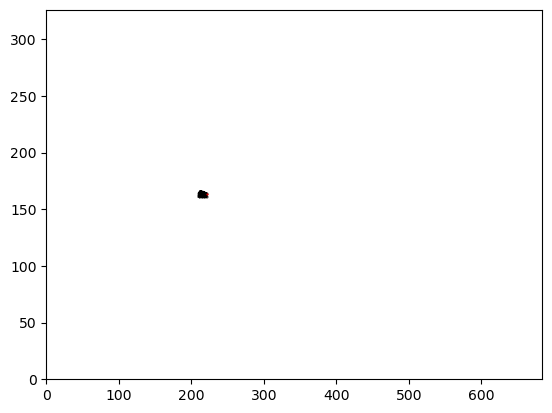

In [21]:
fig, ax = plt.subplots()
ax.set_xlim(0, len(im_binary[0]))
ax.set_ylim(0, len(im_binary))

ax.plot(x, y, color = 'k', marker='.', markersize=0.5)
ax.plot(x_head, y_head, color = 'r', marker='.', markersize=1, label='extremo de la cabeza')
x_head

### pruebas de un solo video

In [9]:
# abro y analizo video
video = cv.VideoCapture('videos/ECO20-45mm-496mVpp-4Hz.mp4')
#lim = [319, 1009, 205, 505]
lim = [319, 950, 250, 505]
t,x,y = tracker(video, lim, SHOW=True)

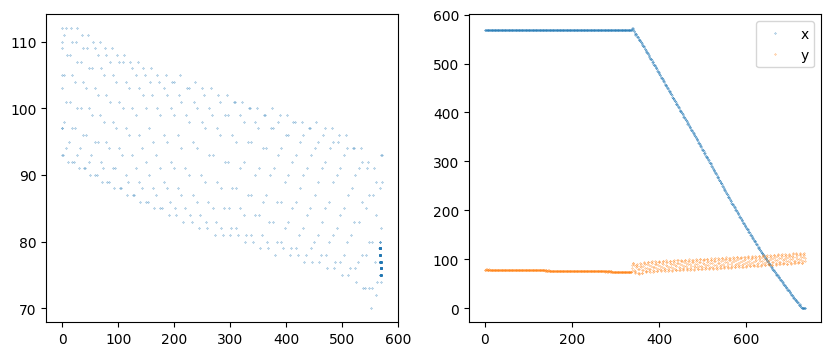

In [36]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 4))
ax1.plot(x, y, '.', markersize=0.5)

ax2.plot(t[:len(x)], x, '.', markersize=0.5,label='x')
ax2.plot(t[:len(x)], y, '.', markersize=0.5, label='y')
ax2.legend()

In [90]:
im = cv.imread('Camo Snapshot 2024-05-17 12-04-24 - 10Hz.jpg')
im_cut = cortar(im, limites=lim)
im_gray = gris(im_cut)
im_decap = guillotina(im_gray, PRUEBA=True)
im_binary = binarize_TAIL(im_decap, PRUEBA=True)
im_sk = skeleton(im_binary, PRUEBA=True)

In [4]:
video = cv.VideoCapture('videos/ECO20-45mm-1,00Vpp-2Hz.mp4')
lim = [319, 1009, 205, 505]
t = track_TAIL(video, lim)

### Maquina de hacer chorizos

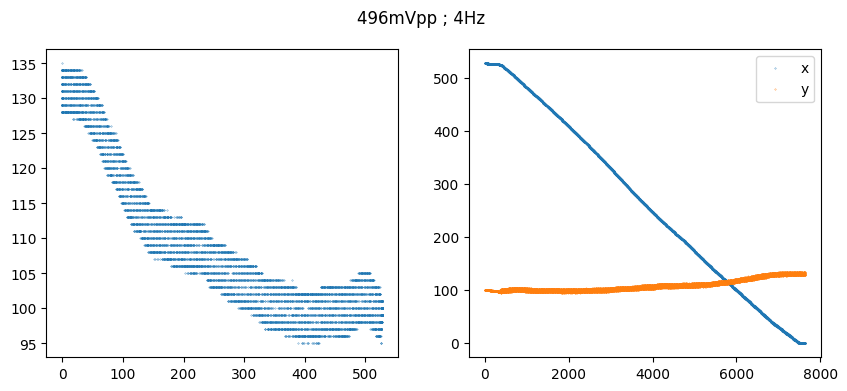

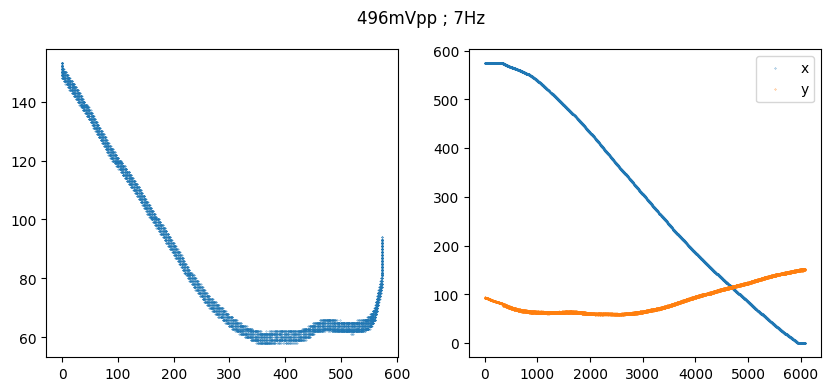

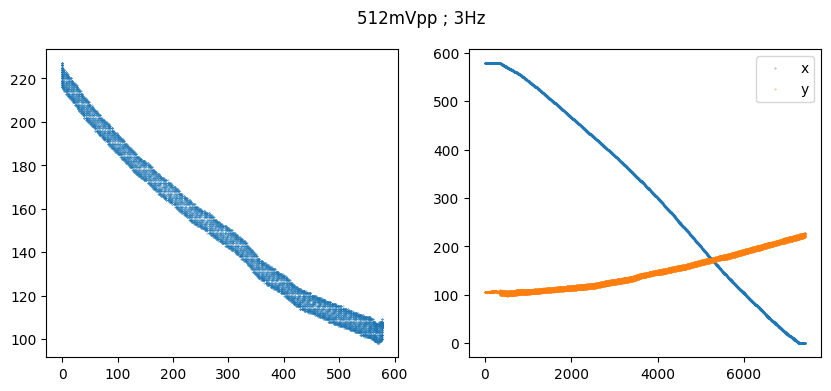

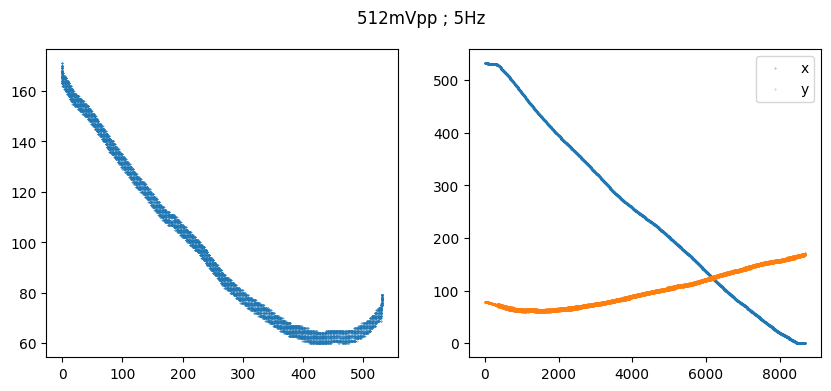

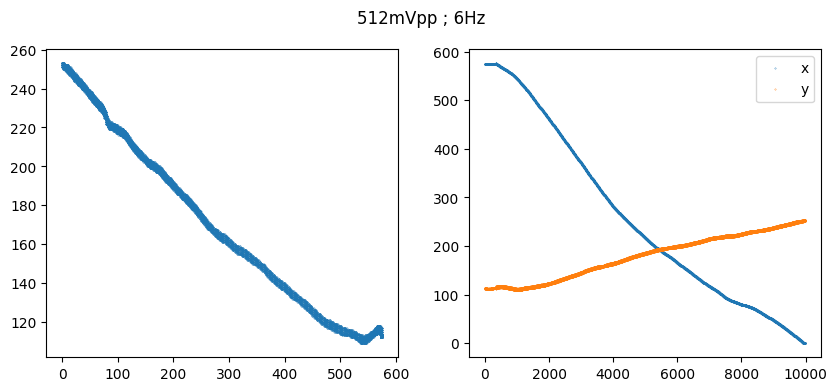

In [4]:
import os

for filename in os.listdir('videos')[15:]:
    spl = filename.split('.')[0].split('-')
    v,f = spl[2],spl[3]
    video = cv.VideoCapture('videos/'+filename)
    lim = [319, 950, 250, 505] #[xleft, xright, ytop, ydown]
    t,x,y = tracker(video, lim, SHOW=False)

    pd.DataFrame().assign(t=t[:len(x)]).assign(x=x).assign(y=y).to_csv(f'ECO20-45mm/{v}-{f}.csv')
    
    fig, [ax1, ax2] = plt.subplots(1, 2, figsize = (10, 4))

    fig.suptitle(f'{v} ; {f}')
    
    ax1.plot(x, y, '.', markersize=0.5)
    ax2.plot(t[:len(x)], x, '.', markersize=0.5,label='x')
    ax2.plot(t[:len(x)], y, '.', markersize=0.5, label='y')
    ax2.legend()